## Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
import seaborn as sns

## Reading in Data

In [3]:
play_features = pd.read_csv('data/prepped/play_features.csv')
play_outcomes = pd.read_csv('data/prepped/play_outcomes.csv')

play_features['rating'] = play_outcomes['rating']
play_features['reviews'] = play_outcomes['reviews']
play_features['installs'] = play_outcomes['installs']

## Small Cleanup
We wanted to show the data distribution and needed to remove the '+' and making it a numeric

In [4]:
play_features['installs'] = play_features['installs'].map(lambda x: x.rstrip('+')).str.replace(',', '')
play_features['installs'] = pd.to_numeric(play_features['installs']) / 1000

In [5]:
play_features.head()

,app,category,size,type,price,content_rating,genres,last_updated,current_ver,android_min_ver,days_since_update,rating,reviews,installs
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,19000000.0,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4_0_3,427.0,4.1,159,10.0
1,Coloring book moana,ART_AND_DESIGN,14000000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4_0_3,419.0,3.9,967,500.0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87000000.0,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4_0_3,221.0,4.7,87510,5000.0
3,Sketch - Draw & Paint,ART_AND_DESIGN,25000000.0,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4_2,275.0,4.5,215644,50000.0
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,28000000.0,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4_4,263.0,4.3,967,100.0


In [6]:
play_features.dtypes

app                   object
category              object
size                 float64
type                  object
price                float64
content_rating        object
genres                object
last_updated          object
current_ver           object
android_min_ver       object
days_since_update    float64
rating               float64
reviews                int64
installs             float64
dtype: object

In [7]:
dummy = pd.get_dummies(play_features['category']).copy()
result = pd.concat([play_features, dummy], axis=1, sort=False)


In [8]:
result.content_rating[result.content_rating == 'Teen'] = 13 
result.content_rating[result.content_rating == 'Everyone'] = 0
result.content_rating[result.content_rating == 'Everyone 10+'] = 10
result.content_rating[result.content_rating == 'Mature 17+'] = 17 
result.content_rating[result.content_rating == 'Adults only 18+'] = 18 
result.content_rating[result.content_rating == 'Unrated'] = -1

result['content_rating'] = result['content_rating'].astype(int)
result['content_rating'].unique()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anac

array([ 0, 13, 10, 17, 18, -1], dtype=int64)

## Data Visualization
In order to get a feel for the data we visualized it

count    9360.000000
mean        4.191838
std         0.515263
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: rating, dtype: float64

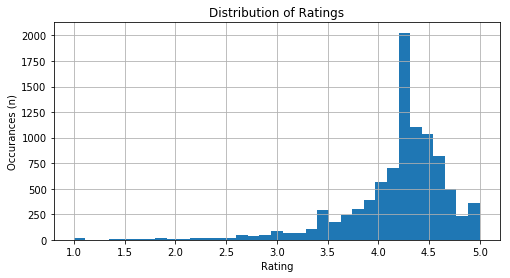

In [15]:
# Distribution of Ratings

plt.figure(figsize=(8,4))

play_features['rating'].hist(bins=35)

plt.xlabel('Rating');
plt.ylabel('Occurances (n)');
plt.title('Distribution of Ratings');

play_features['rating'].describe()

Most of the cells in the Distribution of Ratings follow a bell curve trend, however; when we reach a 5.0 rating it has a suddent spike. This may allude to market tampering and fake ratings.

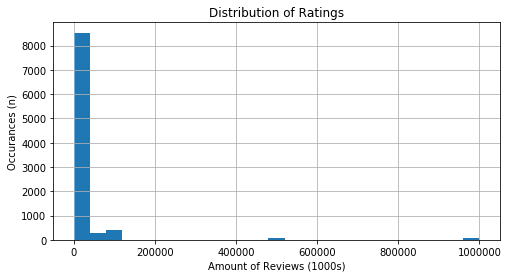

In [7]:
# Distribution of Reviews

plt.figure(figsize=(8,4))

play_features['installs'].hist(bins=25)

plt.xlabel('Amount of Reviews (1000s)');
plt.ylabel('Occurances (n)');
plt.title('Distribution of Ratings');

<Figure size 432x288 with 0 Axes>

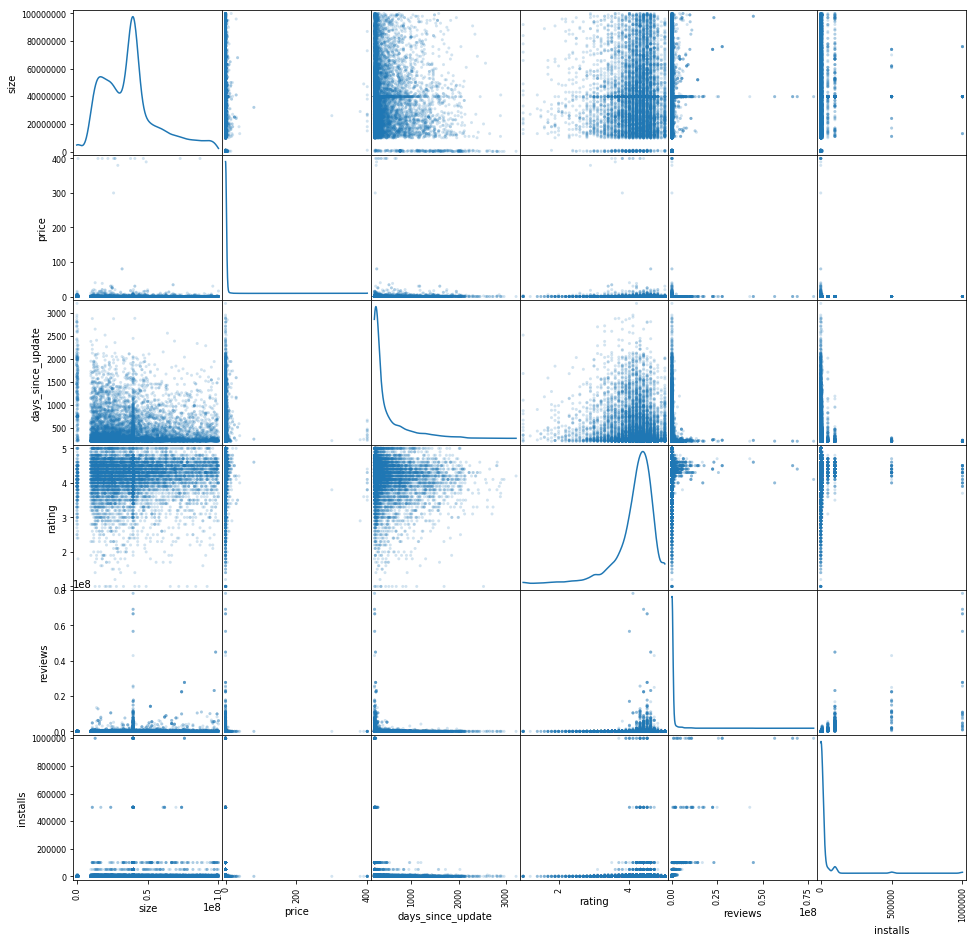

In [37]:
plt.figure()
pd.plotting.scatter_matrix(play_features, alpha=0.2, figsize=(16, 16), diagonal='kde')
plt.show()

## Correlations
Here we determine the correlations between each factor in order to see what is most important to look at

In [9]:
# Correlations
play_features.corr()

,size,price,days_since_update,rating,reviews,installs
size,1.000000,-0.011807,-0.168342,0.046426,0.072289,0.031949
price,-0.011807,1.000000,0.003964,-0.021919,-0.009824,-0.011895
days_since_update,-0.168342,0.003964,1.000000,-0.142966,-0.088182,-0.104371
rating,0.046426,-0.021919,-0.142966,1.000000,0.068133,0.051337
reviews,0.072289,-0.009824,-0.088182,0.068133,1.000000,0.641605
installs,0.031949,-0.011895,-0.104371,0.051337,0.641605,1.000000


In [65]:
# Correlation with category variables
result.corrwith(result.installs).sort_values(ascending=False)

installs               1.000000
reviews                0.641605
COMMUNICATION          0.170445
SOCIAL                 0.067313
GAME                   0.056194
rating                 0.051337
PRODUCTIVITY           0.048619
content_rating         0.045141
size                   0.031949
VIDEO_PLAYERS          0.030314
PHOTOGRAPHY            0.028548
NEWS_AND_MAGAZINES     0.024973
TRAVEL_AND_LOCAL       0.021518
ENTERTAINMENT          0.001878
TOOLS                 -0.007307
SHOPPING              -0.007544
BOOKS_AND_REFERENCE   -0.010855
price                 -0.011895
WEATHER               -0.012042
BEAUTY                -0.012703
EVENTS                -0.013369
PARENTING             -0.013881
ART_AND_DESIGN        -0.014086
COMICS                -0.014659
MAPS_AND_NAVIGATION   -0.015322
LIBRARIES_AND_DEMO    -0.015415
HOUSE_AND_HOME        -0.015556
AUTO_AND_VEHICLES     -0.016691
EDUCATION             -0.017471
FOOD_AND_DRINK        -0.018313
PERSONALIZATION       -0.021275
HEALTH_A

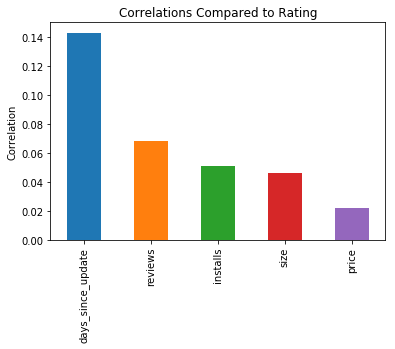

In [34]:
features_rating_corr = play_features.corr()['rating'].drop('rating')
plt.figure()
ax = features_rating_corr.abs().sort_values(ascending=False).plot('bar')
ax.set(title = 'Correlations Compared to Rating', ylabel = 'Correlation')
plt.show()

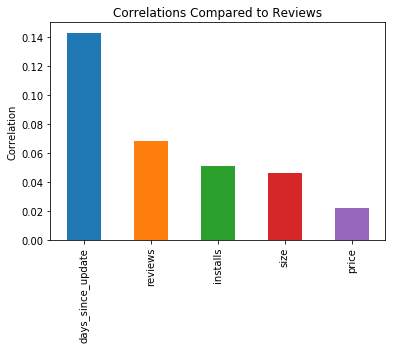

In [35]:
features_reviews_corr = play_features.corr()['reviews'].drop('reviews')
plt.figure()
ax = features_rating_corr.abs().sort_values(ascending=False).plot('bar')
ax.set(title = 'Correlations Compared to Reviews', ylabel = 'Correlation')
plt.show()

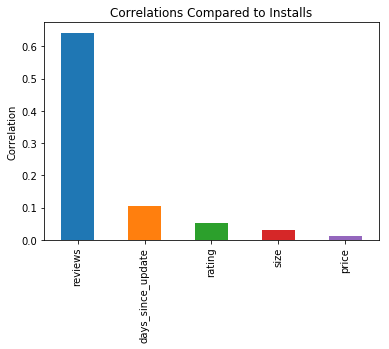

In [38]:
features_installs_corr = play_features.corr()['installs'].drop('installs')
plt.figure()
ax = features_installs_corr.abs().sort_values(ascending = False).plot('bar')
ax.set(title = 'Correlations Compared to Installs', ylabel = 'Correlation')
plt.show()

It appears most of these do not have a strong correlation to each other